In [83]:
import compute_charge_dist as fz
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import PeHeat_Functions as peh
import parametric_fz as fzpar
import dust_size_dist as sizedist

from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import pickle

from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker


import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import MCMCFit as mcmc

%matplotlib inline

In [3]:
filename = "TotaHeating_parametric_50pcent.pkl"
data_dir = "/home/jcibanezm/codes/run/PeHeat/ParametricHeating/"
pkl_file = open("%s%s"%(data_dir, filename))
heatDict = pickle.load(pkl_file)
pkl_file.close

<function close>

In [111]:
too_high = np.where(heatDict["nH"] > 1.0e6)

arrs = []
newdict = {"info":"purged the very large values"}

for key in heatDict.keys():
    #arrs.append(0)
    if key!="info":
        #print(key)
        heatDict[key] = np.delete(heatDict[key], too_high)

In [22]:
def get_abs_eff(Gtot, amin=3.5, amax=2500):
    """
    Get the total heating rape per hydrogem atom.
    """
    from scipy import integrate
    import compute_charge_dist as FZ
    AAtocm        = 1.0e-8
    #amin, amax = 3.5, 2500
    
    #fz.get_avgQabs(Qabs, Gtot)
    
    abseff = lambda grain_size, Gtot, grain_type: FZ.get_avgQabs_asize(grain_size, grain_type, Gtot)*(grain_size)**2*sizedist.dnda(grain_size, grain_type)
    
    Pabs_sil, err = integrate.quad(abseff, amin, amax, args=(Gtot, "silicate"))
    Pabs_carb, err = integrate.quad(abseff, amin, amax, args=(Gtot, "carbonaceous"))
        
    return Pabs_sil + Pabs_carb

In [59]:
print(heatDict["PeHtot"][0]/(heatDict["nH"][0]*Pabs_BT94))

0.042572700482


In [112]:
GTn     = heatDict["Gtot"]*np.sqrt(heatDict["temp"])/heatDict["new_ne"]
GTn_eff = heatDict["Geff"]*np.sqrt(heatDict["temp"])/heatDict["new_ne"]
GTn_oldne = heatDict["Geff"]*np.sqrt(heatDict["temp"])/heatDict["ne"]

In [113]:
epsilon =  heatDict["PeHtot"]/(heatDict["nH"]*Pabs_BT94*heatDict["Gtot"])

In [5]:
# Compute the absorption efficiencies of all data and save to a dictionary,

In [114]:
Pabs_BT94 = 8.1e-26*(2500**(1./6.) - 3.5**(1./6.))

def get_epsilon(psi, temp):
    ephere = 0.049 / (1. + (psi/963.)**(0.73)) + 0.037*(temp/1.0e4)/(1.+(psi/2500.))
    return ephere

def Gamma_BT94(ntot, Geff, temp, ne):
    psi     = Geff * np.sqrt(temp) / ne
    epsilon = get_epsilon(psi, temp)
    Gammahere = 1.3e-24 * epsilon * Geff * ntot
    return Gammahere

In [115]:
Heat_BT94 = Gamma_BT94(heatDict["nH"], heatDict["Geff"], heatDict["temp"], heatDict["new_ne"])
Heat_BT94Upd = Gamma_BT94(heatDict["nH"], heatDict["Gtot"], heatDict["temp"], heatDict["new_ne"])

In [116]:
epsilon_BT94 = Heat_BT94 / (heatDict["nH"]*Pabs_BT94*heatDict["Geff"])
epsilon_BT94Upd = Heat_BT94Upd / (heatDict["nH"]*Pabs_BT94*heatDict["Gtot"])

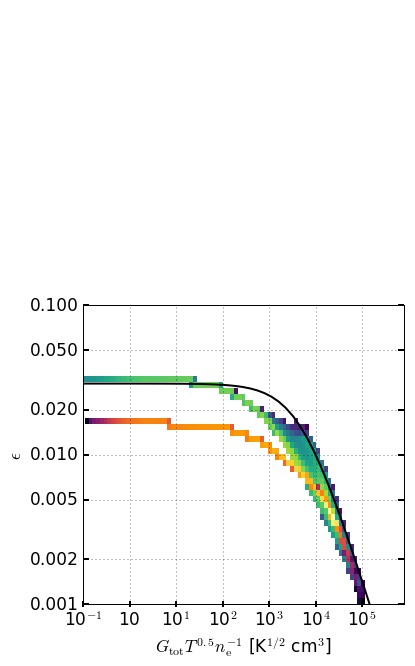

In [118]:
fig = plt.figure(figsize=(5.5, 5))
#ax = fig.add_subplot(111)
ax = fig.add_axes([0.18, 0.14, 0.81, 0.83])

# Formatting tick labels in log scale.
def format_funcx(value, tick_number):
    # find number of multiples of pi/2
    return "10$^{%.i}$"%value

# Formatting tick labels in log scale.
def format_funcy(value, tick_number):
    # find number of multiples of pi/2
    return "%.3f"%(10**(value))

GTnarr = np.logspace(-2, 5.5)
epsarr = 3.0e-2 /(1.+2e-4*GTnarr)
ax.plot(np.log10(GTnarr), np.log10(epsarr), "-k", linewidth=2)

#ax.set_xscale("log")
#ax.set_yscale("log")

cax = ax.hist2d(np.log10(GTn_eff), np.log10(epsilon_BT94/10.), bins=100, norm=LogNorm(), cmap="viridis", range=[[-2, 6], [-3,1]])
cax = ax.hist2d(np.log10(GTn), np.log10(epsilon/10.), bins=100, norm=LogNorm(), cmap="inferno", range=[[-2, 6], [-3,1]])
#cax = ax.hist2d(np.log10(GTn), np.log10(epsilon_BT94Upd), bins=50, norm=LogNorm(), cmap="magma", range=[[-2, 6], [-2,1]])

ax.grid("on")
ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off
ax.set_ylabel("$\epsilon$", fontsize=17)
ax.set_xlabel("$G_{\mathrm{tot}}T^{0.5} n_{\\mathrm{e}}^{-1}$ [K$^{1/2}$ cm$^{3}$]", fontsize=17)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=17)

ax.set_ylim(-3, -1)
ax.set_xlim(-1, 5.9)

majors = [-1, np.log10(0.05), np.log10(0.02), np.log10(0.01), np.log10(0.005), np.log10(0.002), np.log10(0.001)]
ax.yaxis.set_major_locator(ticker.FixedLocator(majors))
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_funcy))

#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_funcx))

fig.show()

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/efficiency.pdf", format="pdf")


In [81]:
print(np.max(epsilon))

0.158766216541


In [ ]:
print()

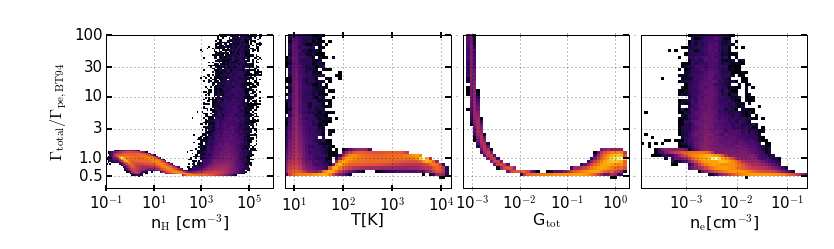

In [120]:
xsize = 11
ysize = 3

nfigs_x = 4
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.183
wpad = 0.10
wwpad = 0.015

xs_panel = 0.84 / nfigs_x 
ys_panel = 0.708 / nfigs_y 

# Formatting tick labels in log scale.
def format_func(value, tick_number):
    # find number of multiples of pi/2
    return "10$^{%.1i}$"%value


# Formatting tick labels in log scale.
def format_funcy(value, tick_number):
    # find number of multiples of pi/2
    if value > 0:
        return "%.0f"%(10**(value))
    else:
        return "%.1f"%(10**(value))
##########################################################################################################
############################             n          #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "5 AA", fontsize=20, horizontalalignment='center')

plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#cax = ax.hist2d(np.log10(heatDict["nH"]), np.log10(heatDict["PeHtot"]), bins=100, norm=LogNorm(), cmap="inferno", range=[[-1, 6.0],[-28, -22]])
ax.hist2d(np.log10(heatDict["nH"]), np.log10(heatDict["PeHtot"]/Heat_BT94), bins=100, norm=LogNorm(), cmap="inferno", range=[[-1, 6.0],[-0.5, 2]])

ax.grid("on")
ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off

ax.set_ylabel("$\Gamma_{\mathrm{total}} / \Gamma_{\mathrm{pe, BT94}}$", fontsize=16)
ax.set_xlabel("n$_{\mathrm{H}}$ [cm$^{-3}$]", fontsize=16, labelpad=-1)

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


majors = [-1, 1, 3, 5]
ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

majors = np.log10([0.5, 1, 3, 10, 30, 100])
ax.yaxis.set_major_locator(ticker.FixedLocator(majors))
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_funcy))


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

#cax = ax.hist2d(np.log10(heatDict["temp"]), np.log10(heatDict["PeHtot"]), bins=100, norm=LogNorm(), cmap="inferno", range=[[0.8, 4.2],[-28, -22]])
ax.hist2d(np.log10(heatDict["temp"]), np.log10(heatDict["PeHtot"]/Heat_BT94), bins=50, norm=LogNorm(), cmap="inferno", range=[[0.8, 4.2],[-0.5, 2]])

ax.grid("on")

ax.set_xlabel("T[K]", fontsize=16, labelpad=-1)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on', direction= 'inout', labelsize=15, pad=0)

ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)
ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

majors = np.log10([0.5, 1, 3, 10, 30, 100])
ax.yaxis.set_major_locator(ticker.FixedLocator(majors))

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

#cax = ax.hist2d(np.log10(heatDict["Gtot"]), np.log10(heatDict["PeHtot"]), bins=100, norm=LogNorm(), cmap="inferno", range=[[-3.2, np.log10(2.0)],[-28, -22]])
ax.hist2d(np.log10(heatDict["Gtot"]), np.log10(heatDict["PeHtot"]/Heat_BT94), bins=50, norm=LogNorm(), cmap="inferno", range=[[-3.2, np.log10(2.0)],[-0.5, 2]])

ax.grid("on")

ax.set_xlabel("G$_{\mathrm{tot}}$", fontsize=16, labelpad=-1)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on', direction= 'inout', labelsize=15)

ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)


#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
majors = [-3, -2, -1, 0]
ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

majors = np.log10([0.5, 1, 3, 10, 30, 100])
ax.yaxis.set_major_locator(ticker.FixedLocator(majors))

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 3
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

#cax = ax.hist2d(np.log10(heatDict["new_ne"]), np.log10(heatDict["PeHtot"]), bins=100, norm=LogNorm(), cmap="inferno", range=[[-3.9, np.log10(np.max(heatDict["new_ne"]))],[-28, -22]])
ax.hist2d(np.log10(heatDict["new_ne"]), np.log10(heatDict["PeHtot"]/Heat_BT94), bins=50, norm=LogNorm(), cmap="inferno", range=[[-3.9,  np.log10(np.max(heatDict["new_ne"]))],[-0.5, 2]])

ax.grid("on")

ax.set_xlabel("n$_{\mathrm{e}}$[cm$^{-3}$]", fontsize=16, labelpad=-1)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on', direction= 'inout', labelsize=15)
#ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)

#ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off


ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

majors = np.log10([0.5, 1, 3, 10, 30, 100])
ax.yaxis.set_major_locator(ticker.FixedLocator(majors))



fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/HeatingRatios.pdf", format="pdf")
#fig.savefig("/Users/juan/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/TotalHeating_parametric.pdf", format="pdf")

fig.show()

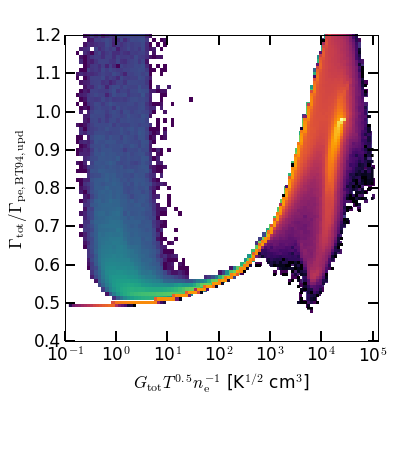

In [121]:
fig = plt.figure(figsize=(5.5,5))

ax = fig.add_axes([0.185, 0.13, 0.79, 0.85])

from matplotlib.ticker import MaxNLocator
def format_func(value, tick_number):
    return "10$^{%i}$"%value


GTn = (heatDict["Gtot"])*np.sqrt(heatDict["temp"])/heatDict["new_ne"]

#ax.hist2d(np.log10(GTn), heatDict["PeHtot"]/Heat_BT94Upd, bins=100, norm=LogNorm(), cmap="inferno")
ax.hist2d(np.log10(GTn), heatDict["PeHtot"]/Heat_BT94, bins=100, norm=LogNorm(), cmap="viridis", range=[[-2, 5.1],[0.1, 1.2]])
ax.hist2d(np.log10(GTn), heatDict["PeHtot"]/Heat_BT94Upd, bins=100, norm=LogNorm(), cmap="inferno")

#ax.set_ylabel("T [K]", fontsize=25)
#
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=17, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=17, direction="in")


#ax.set_ylim(-0.9, 4.99)
ax.set_ylabel("$\Gamma_{\mathrm{tot}} /\Gamma_{\mathrm{pe, BT94, upd}}$", fontsize=17)
ax.set_xlabel("$G_{\mathrm{tot}}T^{0.5} n_{\\mathrm{e}}^{-1}$ [K$^{1/2}$ cm$^{3}$]", fontsize=17)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
#ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

#ax.set_yscale("log")

ax.set_xlim(-1, 5.1)
ax.set_ylim(0.4, 1.2)

#fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/Ratio_HeatingUpd.pdf", format="pdf")
#fig.savefig("/Users/juan/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/TotalHeating_parametric_GTn.pdf", format="pdf")


fig.show()

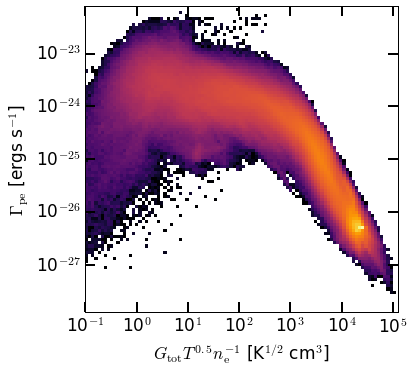

In [150]:
fig = plt.figure(figsize=(5.5,5))

ax = fig.add_axes([0.19, 0.13, 0.79, 0.85])

from matplotlib.ticker import MaxNLocator
def format_func(value, tick_number):
    return "10$^{%i}$"%value


GTn = (heatDict["Gtot"])*np.sqrt(heatDict["temp"])/heatDict["new_ne"]

#ax.hist2d(np.log10(GTn), np.log10(Heat_BT94), bins=100, norm=LogNorm(), cmap="inferno", range=[[-1, 5.1],[-27, -22]])
ax.hist2d(np.log10(GTn_oldne), np.log10(Heat_BT94), bins=100, norm=LogNorm(), cmap="inferno", range=[[-1, 5.1],[-27.9, -22.1]])

#ax.set_ylabel("T [K]", fontsize=25)
#
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=17, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=17, direction="in")


#ax.set_ylim(-0.9, 4.99)
ax.set_ylabel("$\Gamma_{\mathrm{pe}}$ [ergs s$^{-1}$]", fontsize=17)
ax.set_xlabel("$G_{\mathrm{tot}}T^{0.5} n_{\\mathrm{e}}^{-1}$ [K$^{1/2}$ cm$^{3}$]", fontsize=17)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

#ax.set_yscale("log")

ax.set_xlim(-1, 5.1)
ax.set_ylim(-27.9, -22.1)

#ax.set_title("Bakes & Tielens (1994)")

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/TotalHeating_BT94_GTn.pdf", format="pdf")
#fig.savefig("/Users/juan/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/TotalHeating_parametric_GTn.pdf", format="pdf")


fig.show()

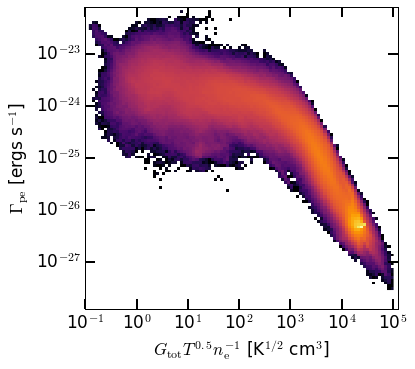

In [149]:
fig = plt.figure(figsize=(5.5,5))

ax = fig.add_axes([0.19, 0.13, 0.79, 0.84])

from matplotlib.ticker import MaxNLocator
def format_func(value, tick_number):
    return "10$^{%i}$"%value


GTn = (heatDict["Gtot"])*np.sqrt(heatDict["temp"])/heatDict["new_ne"]

totalMass = np.sum(heatDict["cell_mass"])
ax.hist2d(np.log10(GTn), np.log10(Heat_BT94Upd), bins=100, norm=LogNorm(), cmap="inferno", normed=True)
#ax.hist2d(np.log10(GTn), np.log10(Heat_BT94Upd), bins=100, norm=LogNorm(), cmap="inferno", weights=heatDict["cell_mass"]/totalMass, normed=True)

#ax.set_ylabel("T [K]", fontsize=25)
#
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=17, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=17, direction="in")


#ax.set_ylim(-0.9, 4.99)
ax.set_ylabel("$\Gamma_{\mathrm{pe}}$ [ergs s$^{-1}$]", fontsize=17)
ax.set_xlabel("$G_{\mathrm{tot}}T^{0.5} n_{\\mathrm{e}}^{-1}$ [K$^{1/2}$ cm$^{3}$]", fontsize=17)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

#ax.set_yscale("log")

ax.set_xlim(-1, 5.1)
#ax.set_xlim(np.log10(-33), np.log10(-22))
ax.set_ylim(-27.9, -22.1)

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/TotalHeating_BT94upd_GTn.pdf", format="pdf")
#fig.savefig("/Users/juan/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/TotalHeating_parametric_GTn.pdf", format="pdf")


fig.show()